<h1 align="center" style="margin: 0; font-size: 36px;">Computational Intelligence for Optimization</h1>
<br>
<h1 align="center" style="margin: 0; font-size: 30px;">Music Festival Lineup Optimization</h1>

<br>

**Group members:**<br>
Bárbara Capitão - 20211532@novaims.unl.pt <br>
Carolina Silvestre - 20211512@novaims.unl.pt <br>
Francisco Pontes -  <br>
Lara Leandro - 20211632@novaims.unl.pt <br>


### Objective
Design the optimal festival lineup by assigning each artist to a specific stage and time slot, optimizing three key criteria:

1. **Prime Slot Popularity**  
   Maximize the total popularity of artists scheduled in the final time slot (prime slot) on each stage.

2. **Genre Diversity**  
   Maximize the diversity of musical genres across stages in each time slot. For every time slot, compute the average number of unique genres, normalized by the number of stages.

3. **Conflict Penalty**  
   Minimize fan base conflicts by avoiding scheduling artists with overlapping fan bases at the same time on different stages. This penalty is calculated using a provided pairwise conflict matrix.

---

### Constraints
- Each artist must be assigned to **exactly one stage and one time slot**.
- All stages must have **the same number of time slots**.
- All time slots occur **simultaneously** across all stages.
- No artist can be scheduled more than once or left unassigned.

---

### Representation
- The lineup is modeled as a 2D matrix:  
  `lineup[stage][slot] = artist_id`
- There are **5 stages and 7 time slots**, for a total of **35 artists**.

---



the fitness function
➔ at least 3 mutation operators
➔ at least 2 crossover operators
➔ at least 2 selection mechanisms

## Imports and Setup

In [5]:
import sys
sys.path.append(r'C:\Users\laral\CIFO-24-25')

from copy import deepcopy
from library.algorithms.genetic_algorithms.algorithm import genetic_algorithm, get_best_ind
from library.algorithms.genetic_algorithms.crossover import standard_crossover, cycle_crossover
from library.algorithms.genetic_algorithms.mutation import binary_standard_mutation, swap_mutation, inversion_mutation
from library.solution import Solution


In [6]:
import numpy as np
import pandas as pd
import random
import itertools
from collections import defaultdict
from typing import Callable


random.seed(42)
np.random.seed(42)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Load Data

In [9]:
artists = pd.read_csv('artists(in).csv')

In [10]:
conflict_matrix = pd.read_csv('conflicts(in).csv', index_col=0)

In [11]:
artists.rename(columns={'Unnamed: 0': 'artist_id'}, inplace=True)
artists.set_index('artist_id', inplace=True)

In [12]:
artists 

,name,genre,popularity
artist_id,,,
0,Midnight Echo,Rock,75
1,Solar Flare,Electronic,78
2,Velvet Pulse,Jazz,35
3,Neon Reverie,Electronic,100
4,The Silver Owls,Classical,85
5,Echo Chamber,Electronic,98
6,Aurora Skies,Pop,75
7,Static Mirage,Rock,94
8,Crimson Harmony,Classical,20


In [13]:
conflict_matrix

,Midnight Echo,Solar Flare,Velvet Pulse,Neon Reverie,The Silver Owls,Echo Chamber,Aurora Skies,Static Mirage,Crimson Harmony,Deep Resonance,...,Rhythm Alchemy,Cloud Nine Collective,Hypnotic Echoes,The Polyrhythm Syndicate,Harmonic Dissonance,Turbo Vortex,The Jazz Nomads,The Bassline Architects,Cosmic Frequency,Parallel Dimension
Midnight Echo,0.00,0.00,0.00,0.20,0.50,0.00,0.80,1.00,0.20,0.50,...,0.20,0.80,1.00,1.00,0.65,1.00,0.40,0.40,1.00,0.20
Solar Flare,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.65,...,0.20,0.65,0.00,0.65,0.40,0.40,0.40,0.00,0.00,1.00
Velvet Pulse,0.00,0.00,0.00,1.00,0.50,0.00,0.65,1.00,0.50,1.00,...,1.00,1.00,0.40,1.00,0.70,0.00,1.00,0.15,1.00,0.40
Neon Reverie,0.20,1.00,1.00,0.00,0.20,0.90,0.20,1.00,0.00,1.00,...,0.00,0.00,0.00,0.20,0.65,0.65,0.20,0.00,0.20,1.00
The Silver Owls,0.50,0.00,0.50,0.20,0.00,1.00,0.00,1.00,0.90,0.00,...,1.00,0.65,0.00,0.20,0.90,0.20,0.20,0.40,1.00,0.00
Echo Chamber,0.00,1.00,0.00,0.90,1.00,0.00,0.50,1.00,0.80,0.65,...,0.00,0.20,0.00,0.50,0.65,0.15,0.50,0.40,1.00,1.00
Aurora Skies,0.80,0.00,0.65,0.20,0.00,0.50,0.00,1.00,1.00,0.40,...,0.00,1.00,1.00,0.20,0.80,0.65,0.20,1.00,0.20,0.50
Static Mirage,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.20,0.20,...,1.00,0.80,0.90,0.65,0.00,1.00,0.40,0.50,1.00,0.20
Crimson Harmony,0.20,0.00,0.50,0.00,0.90,0.80,1.00,0.20,0.00,0.00,...,0.00,0.40,0.65,0.00,0.90,0.15,1.00,1.00,0.65,0.15
Deep Resonance,0.50,0.65,1.00,1.00,0.00,0.65,0.40,0.20,0.00,0.00,...,0.90,0.50,0.20,1.00,0.70,1.00,1.00,0.50,0.00,0.20


### Coherence Check 

In [15]:
num_artists = len(artists)
num_conflict_rows, num_conflict_cols = conflict_matrix.shape

# Ensure the number of artists matches the expected total
expected_artists = 5 * 7  # 5 stages x 7 slots
consistency_check = (num_artists == expected_artists and 
                     num_conflict_rows == expected_artists and 
                     num_conflict_cols == expected_artists)

# Ensure conflict matrix aligns with artist names
artist_names_match = list(artists['name']) == list(conflict_matrix.columns)

consistency_check, artist_names_match

(True, True)

### Artist Lineup Solution

In [17]:
class ArtistLineupSolution(Solution):
    def __init__(self, conflict_matrix, artists, repr=None):
        self.conflict_matrix = conflict_matrix
        self.artists = artists

        if repr is None:
            repr = self.random_initial_representation()
        else:
            self._validate_repr(repr)

        # To help otimize fitness function

        self.conflict_matrix = (
            conflict_matrix.to_numpy() if not isinstance(conflict_matrix, np.ndarray) else conflict_matrix
        )
        self.artist_names = artists['name'].to_numpy()
        self.artist_name_to_index = {name: i for i, name in enumerate(self.artist_names)}
        self.artist_popularities = artists['popularity'].to_numpy()
        self.artist_genres = artists['genre'].to_numpy()
        self.unique_genres = np.unique(self.artist_genres)
        self.genre_to_index = {genre: i for i, genre in enumerate(self.unique_genres)}


        super().__init__(repr=repr)

    def random_initial_representation(self):
        artist_indices = list(range(35))
        random.shuffle(artist_indices)
        # 5 stages × 7 slots
        return [artist_indices[i:i + 7] for i in range(0, 35, 7)]

    def _validate_repr(self, repr):
        # Must be 5 rows and 7 columns, with unique values from 0 to 34
        if not isinstance(repr, list):
            raise TypeError("Representation must be a list of lists")

        if len(repr) != 5 or not all(len(row) == 7 for row in repr):
            raise ValueError("Representation must be 5 rows of 7 integers")

        flat = [a for row in repr for a in row]

        if set(flat) != set(range(35)):
            raise ValueError("Representation must contain all 35 artist indices exactly once")

    def fitness(self):
        lineup = self.repr  # 5 rows (stages) × 7 columns (time slots), each cell contains an artist ID
    
        # --- Prime Slot Popularity ---
        # Extract the artist IDs from the last time slotacross all stages 
        prime_slot_indices = [lineup[stage][6] for stage in range(5)]
        
        # Get the popularity scores for those artists
        prime_popularity = self.artist_popularities[prime_slot_indices]
        
        # Normalize the sum of popularity scores by dividing by (5 artists × max popularity score of 100)
        prime_score = prime_popularity.sum() / (5 * 100)
    
        # --- Genre Diversity Score ---
        # Initialize total diversity score
        total_diversity = 0
        
        # Loop over each time slot (column)
        for slot in range(7):
            genre_indices = set()  # Track unique genres in this time slot
            
            # For each stage (row), collect the genre of the artist in this slot
            for stage in range(5):
                artist_idx = lineup[stage][slot]
                genre = self.artist_genres[artist_idx]
                genre_indices.add(self.genre_to_index[genre])  # Use index for uniqueness
            
            # Normalize diversity by number of unique genres
            total_diversity += len(genre_indices) / len(self.unique_genres)
        
        # Average genre diversity score across all 7 time slots
        genre_score = total_diversity / 7
    
        # --- Conflict Penalty Score ---
        total_conflict = 0  # Accumulate conflict values between artists
        max_possible_conflict = 0  # Total number of possible artist pairs per slot
        
        # Loop over each time slot
        for slot in range(7):
            # Collect the artist IDs scheduled in this time slot across all 5 stages
            slot_artists = [lineup[stage][slot] for stage in range(5)]
            
            # Compare each unique pair of artists to calculate conflict
            for i in range(5):
                for j in range(i + 1, 5):
                    artist1 = slot_artists[i]
                    artist2 = slot_artists[j]
                    total_conflict += self.conflict_matrix[artist1, artist2]
                    max_possible_conflict += 1  # Count this pair as a possible conflict
        
        # Normalize and invert conflict score: lower conflict gives higher score
        conflict_score = 1 - (total_conflict / max_possible_conflict) if max_possible_conflict else 1
    
        # --- Final Fitness Score ---
        # Average the three components: popularity, genre diversity, and conflict avoidance
        return (prime_score + genre_score + conflict_score) / 3


In [18]:
class ArtistLineupSolutionGA(ArtistLineupSolution):
    def __init__(
        self,
        conflict_matrix,
        artists,
        mutation_function,
        crossover_function,
        repr=None
    ):
        self.mutation_function = mutation_function
        self.crossover_function = crossover_function
        super().__init__(conflict_matrix, artists, repr)

    def crossover(self, other_solution):
        offspring1_repr, offspring2_repr = self.crossover_function(self.repr, other_solution.repr)
        return (
            ArtistLineupSolutionGA(
                conflict_matrix=self.conflict_matrix,
                artists=self.artists,
                mutation_function=self.mutation_function,
                crossover_function=self.crossover_function,
                repr=offspring1_repr
            ),
            ArtistLineupSolutionGA(
                conflict_matrix=self.conflict_matrix,
                artists=self.artists,
                mutation_function=self.mutation_function,
                crossover_function=self.crossover_function,
                repr=offspring2_repr
            )
        )

    def mutation(self, mut_prob):
        new_repr = self.mutation_function(self.repr, mut_prob)
        return ArtistLineupSolutionGA(
            conflict_matrix=self.conflict_matrix,
            artists=self.artists,
            mutation_function=self.mutation_function,
            crossover_function=self.crossover_function,
            repr=new_repr
        )


### Helper Functions

In [20]:
# Helper function to flatten a 2D matrix into a single list
def flatten(lineup):
    return [artist for row in lineup for artist in row]

# Helper to reshape a flat list back into a 5x7 matrix
def to_matrix(flat):
    return [flat[i*7:(i+1)*7] for i in range(5)]

In [21]:
# Function to repair duplicates/missing values after crossover
def repair(child):
    flat = flatten(child)
    seen = set()
    duplicates = []

    # Finds duplicates
    for i, artist in enumerate(flat):
        if artist in seen:
            duplicates.append(i)
        else:
            seen.add(artist)
            
    # Finds missing artists
    missing = list(set(range(35)) - seen)
    random.shuffle(missing) # Shuffle to avoid bias

    # Replace the duplicate positions with missing artist IDs
    for i, idx in enumerate(duplicates):
        flat[idx] = missing[i]

    
    return to_matrix(flat)

### Mutation Functions

In [23]:
def block_move_mutation_matrix(lineup, mut_prob):
    """
    Applies block move mutation to a lineup matrix.

    Block move mutation selects a random contiguous block of artists, 
    removes it, and reinserts it at another valid position, ensuring no duplication 
    and preserving the 5x7 shape.

    Parameters:
    ----------
    lineup : list of list of int
        A 5x7 matrix representing the lineup. Each artist ID must be unique.
    mut_prob : float
        Probability of applying the mutation (between 0 and 1).

    Returns:
    -------
    list of list of int
        A mutated 5x7 matrix with a moved block, or a copy of the original.
    """
    if random.random() <= mut_prob:

        # Flatten matrix to 1D permutation
        flat = flatten(lineup)
    
        # Randomly selects start and end index of block
        start = random.randint(0, len(flat) - 2)
        end = random.randint(start + 1, len(flat))  # at least size 1

        # Extract the block and remove it from the rest of the list
        block = flat[start:end]
        remainder = flat[:start] + flat[end:]
    
        # Choose a new position to insert the block 
        insert_pos = random.randint(0, len(remainder))
        new_flat = remainder[:insert_pos] + block + remainder[insert_pos:]
    
        # Reshape to 5x7 matrix
        new_lineup = to_matrix(new_flat)
    
        return new_lineup
        
    else:
        return deepcopy(lineup)

        


In [24]:
def scramble_mutation_matrix(lineup, mut_prob):
    """
    Applies scramble mutation to a lineup matrix.

    Scramble mutation randomly selects a rectangular block (possibly from multiple stages and slots),
    flattens and shuffles it, then reinserts it in the same location. The size and position of the block 
    vary randomly. Ensures all artists are preserved and only reordered within the block.

    Parameters:
    ----------
    lineup : list of list of int
        A 5x7 matrix representing the lineup. Each artist ID must be unique.
    mut_prob : float
        Probability of applying the mutation (between 0 and 1).

    Returns:
    -------
    list of lists: A new 5x7 lineup after mutation (or a copy if no mutation occurs).
    """

    if random.random() <= mut_prob:
        new_lineup = deepcopy(lineup)

        # Randomly choose block dimensions
        start_stage = random.randint(0, 4)
        end_stage = random.randint(start_stage, 4)

        start_slot = random.randint(0, 6)
        end_slot = random.randint(start_slot, 6)

        # Extract and flatten the sub-block
        sub_block = [
            new_lineup[s][t]
            for s in range(start_stage, end_stage + 1)
            for t in range(start_slot, end_slot + 1)
        ]
        random.shuffle(sub_block) # Shuffle the values

        # Reinsert shuffled values
        idx = 0
        for s in range(start_stage, end_stage + 1):
            for t in range(start_slot, end_slot + 1):
                new_lineup[s][t] = sub_block[idx]
                idx += 1

        return new_lineup
        
    else:
        return deepcopy(lineup)




In [25]:
def conflict_reduction_mutation(lineup, mut_prob):
    """
    Applies a conflict-aware mutation to reduce fan base overlap in the lineup.

    Parameters:
    ----------
    lineup : list of list of int
        A 5x7 matrix representing the lineup. Each artist ID must be unique.
    mut_prob : float
        Probability of applying the mutation (between 0 and 1).

    Returns:
    -------
    list of lists: A new 5x7 lineup after mutation (or a copy if no mutation occurs).
    """
    # Ensure we work with a NumPy array internally for easy slicing
    lineup = np.array(lineup)

    if random.random() <= mut_prob:
        new_lineup = deepcopy(lineup)

        worst_slot = -1  # Initialize variable that will hold the index of the slot with the worst conflict
        worst_score = -1  # Initialize the worst conflict score

        # Find time slot with highest conflict
        for slot in range(7):
            conflict = 0
            
            # Compare every pair of artists scheduled at the same slot
            for i in range(5):
                for j in range(i + 1, 5):
                    a = new_lineup[i, slot]
                    b = new_lineup[j, slot]
                    conflict += conflict_matrix.iat[a, b] #Summing the conflict between pairs
                    
            # Keeping track of the slot with the highest conflict
            if conflict > worst_score:
                worst_score = conflict
                worst_slot = slot

        # If exist slots with conflicts, try to reduce it
        if worst_slot != -1:
            source_stage = random.randint(0, 4) # Randomly pick a stage
            target_slot = random.randint(0, 6) # Randomly pick a different slot 
            
            while target_slot == worst_slot: # Making sure the new slot is different from the one with most conflict 
                target_slot = random.randint(0, 6)

            # Swap artists
            new_lineup[source_stage, worst_slot], new_lineup[source_stage, target_slot] = (
                new_lineup[source_stage, target_slot],
                new_lineup[source_stage, worst_slot],
            )

        return new_lineup.tolist()  # Convert to list of lists before returning
    else:
        return deepcopy(lineup).tolist()  


### Mutation Strategy: Why These 3 Functions Were Chosen

These three mutation functions were selected to balance global exploration, local variation, and problem-specific optimization in the lineup generation process. Each one targets a different kind of structural change in the 5x7 matrix while ensuring that the mutations preserve the uniqueness and validity of the lineup.

#### 1. `block_move_mutation_matrix`

This function is designed for global structural changes. It works by flattening the 5x7 lineup into a 1D list, selecting a contiguous block of artists, and moving that block to a new position. The 1D approach simplifies this operation, allowing for easy slicing and reinsertion without worrying about row or column boundaries in the matrix. It helps explore entirely different lineup configurations by shifting artist order on a larger scale.

#### 2. `scramble_mutation_matrix`

This function introduces local variation by randomly selecting a rectangular subregion of the lineup and shuffling the artists within that block. Since the mutation is tied to a specific region in the matrix, it's more intuitive to perform this directly in 2D. This operator preserves the general structure of the lineup while introducing diversity in smaller, spatially coherent areas.

#### 3. `conflict_reduction_mutation`

This mutation is guided by domain knowledge. It targets the time slot with the highest fanbase conflict (as determined by a conflict matrix) and reduces the conflict by swapping artists within that slot and another randomly selected one. This mutation operates in 2D and is designed to directly address a key constraint in lineup quality: minimizing artist overlap for fans. Unlike the other two, it’s not random but purpose-driven.

### Summary

* `block_move_mutation_matrix` is used for large, structure-altering changes by working in 1D.
* `scramble_mutation_matrix` introduces small, local variations in-place within the 2D layout.
* `conflict_reduction_mutation` directly targets high-conflict areas using problem-specific logic.

Together, these functions provide a mix of random and targeted mutation strategies, supporting both exploration of new solutions and refinement of existing ones.


| Mutation Function             | Mutation Type         | Scope           | Purpose                                      | Data Representation           |
| ----------------------------- | --------------------- | --------------- | -------------------------------------------- | ----------------------------- |
| `block_move_mutation_matrix`  | Move contiguous block | Global          | Large-scale rearrangement of artist order    | Flattened 1D list             |
| `scramble_mutation_matrix`    | Shuffle sub-block     | Local           | Small local randomization within a region    | 2D matrix                     |
| `conflict_reduction_mutation` | Targeted swap         | Conflict-driven | Reduce fanbase conflicts by swapping artists | 2D matrix with conflict logic |


### Crossover Functions

In [29]:
def row_wise_crossover(parent1_repr, parent2_repr):
    """
    Performs a row-wise crossover (swap stages) with conflict-free repair.

    Each child starts as a copy of a parent and randomly swaps full rows.
    Afterward, duplicates are fixed and missing artist IDs are inserted.

    Args:
        parent1_repr (list of lists): 5x7 matrix, valid permutation of artist IDs.
        parent2_repr (list of lists): 5x7 matrix, valid permutation of artist IDs.

    Returns:
        tuple: Two valid 5x7 offspring (list of lists), each using artist IDs 0–34 once.
    """

    # Start with copies
    child1 = [row.copy() for row in parent1_repr]
    child2 = [row.copy() for row in parent2_repr]

    # Randomly choose rows/stages to swap between parents
    rows_to_swap = random.sample(range(5), k=random.randint(1, 5))
    for row in rows_to_swap:
        child1[row], child2[row] = child2[row], child1[row]

    # After te swap some artists can be duplicated or missing, so we use repair function to solve
    return repair(child1), repair(child2)


In [30]:
def time_slot_wise_crossover(parent1_repr, parent2_repr):
    """
    Performs a time-slot-wise crossover (swap columns) with conflict-free repair.

    Each child starts as a copy of a parent and randomly swaps full columns (time slots).
    Afterward, duplicates are fixed and missing artist IDs are inserted.

    Args:
        parent1_repr (list of lists): 5x7 matrix, valid permutation of artist IDs.
        parent2_repr (list of lists): 5x7 matrix, valid permutation of artist IDs.

    Returns:
        tuple: Two valid 5x7 offspring (list of lists), each using artist IDs 0–34 once.
    """

    # Start with copies
    child1 = [row.copy() for row in parent1_repr]
    child2 = [row.copy() for row in parent2_repr]

    # Randomly choose columns/time slots to swap between parents
    cols_to_swap = random.sample(range(7), k=random.randint(1, 7))

    for col in cols_to_swap:
        for row in range(5):
            child1[row][col], child2[row][col] = child2[row][col], child1[row][col]

    # After te swap some artists can be duplicated or missing, so we use repair function to solve
    return repair(child1), repair(child2)


### Selection Functions

In [32]:
def tournament_selection(population, maximization=False, size=3):
    # Randomly selects 3 individuals from population
    selected = random.sample(population, size)
    
    if maximization:
        # If is a maximization problem selects the individual with the highest fitness
        best = max(selected, key=lambda ind: ind.fitness())
        
    else:
        # If is a minimization problem selects the individual with the smallest fitness
        best = min(selected, key=lambda ind: ind.fitness())
        
    return deepcopy(best)


In [33]:
def rank_based_selection(population,  maximization = True):
    # Sort individuals by fitness
    
    # If maximization, highest fitness gets rank 1 (best)
    # If minimization, lowest fitness gets rank 1 (best)
    sorted_pop = sorted(population, key=lambda ind: ind.fitness(), reverse=maximization)

    # Assign ranks: best individual gets highest rank (len), worst gets 1
    # This ensures the best individual has the highest chance to be selected
    ranks = list(range(len(sorted_pop), 0, -1))  
    total_rank = sum(ranks)  # Sum of all ranks, used to normalize selection probability

    # Generate a random number between 0 and total of ranks
    pick = random.uniform(0, total_rank)

    # Iterate over the population and sum up ranks
    current = 0
    for ind, rank in zip(sorted_pop, ranks):
        current += rank
        if current >= pick:
            # Once the random number falls in the "rank box", select the individual
            return deepcopy(ind)


## Grid Search of Parameters

In [35]:
POP_SIZE = 100
GENERATIONS = 50

grid_params = {
    "crossover": [
        {
            "function": row_wise_crossover,
            "mut_prob": 0.8
        },
        {
            "function": time_slot_wise_crossover,
            "mut_prob": 0.8
        }
    ],
    "mutation": [
        {
            "function": block_move_mutation_matrix,
            "xo_prob": 0.2
        },
        {
            "function": scramble_mutation_matrix,
            "xo_prob": 0.2
        },
        {
            "function": conflict_reduction_mutation,
            "xo_prob": 0.2
        }
    ],
    "selection": [
        tournament_selection,
        rank_based_selection
    ],
    "elitism": [True, False]
}

fitness_dfs = {}

# Generate all combinations of the grid parameters
grid = list(itertools.product(
    grid_params["crossover"],
    grid_params["mutation"],
    grid_params["selection"],
    grid_params["elitism"]
))


for crossover_cfg, mutation_cfg, selection_function, elitism in grid:
    # Create empty dataframe for each configuration
    # Columns have the fitness in each generation, rows will have results for each run
    df = pd.DataFrame(columns=range(GENERATIONS))  # Shape will be 30 x 200

    # Get crossover and mutation functions and probabilities from the grid
    crossover_function = crossover_cfg.get("function")
    xo_prob = crossover_cfg.get("xo_prob", 0.8)

    mutation_function = mutation_cfg.get("function")
    mut_prob = mutation_cfg.get("mut_prob", 0.2)

    config_results = []
    start_time = time.time()

    for run_nr in range(20):  # Run 20 times
        _, fitness_over_gens = genetic_algorithm(
            initial_population=[
                ArtistLineupSolutionGA(
                    crossover_function=crossover_function,
                    mutation_function=mutation_function,
                    conflict_matrix=conflict_matrix,
                    artists=artists
                ) for _ in range(POP_SIZE)
            ],
            max_gen=GENERATIONS,
            selection_algorithm=selection_function,
            maximization=True,
            xo_prob=xo_prob,
            mut_prob=mut_prob,
            elitism=elitism
        )
        config_results.append(fitness_over_gens)
        df.loc[run_nr] = fitness_over_gens

    # Create a label for the configuration
    config_label = (
        f"{crossover_function.__name__}{xo_prob}_"
        f"{mutation_function.__name__}{mut_prob}_"
        f"{selection_function.__name__}_elitism={elitism}"
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f"Finish {config_label} in {elapsed_time:.2f} seconds")
   
    # Save configuration results in the dictionary
    fitness_dfs[config_label] = df


Finish row_wise_crossover0.8_block_move_mutation_matrix0.2_tournament_selection_elitism=True in 238.31 seconds
Finish row_wise_crossover0.8_block_move_mutation_matrix0.2_tournament_selection_elitism=False in 216.37 seconds
Finish row_wise_crossover0.8_block_move_mutation_matrix0.2_rank_based_selection_elitism=True in 1964.98 seconds
Finish row_wise_crossover0.8_block_move_mutation_matrix0.2_rank_based_selection_elitism=False in 1998.75 seconds
Finish row_wise_crossover0.8_scramble_mutation_matrix0.2_tournament_selection_elitism=True in 196.54 seconds
Finish row_wise_crossover0.8_scramble_mutation_matrix0.2_tournament_selection_elitism=False in 2260.45 seconds
Finish row_wise_crossover0.8_scramble_mutation_matrix0.2_rank_based_selection_elitism=True in 1954.00 seconds
Finish row_wise_crossover0.8_scramble_mutation_matrix0.2_rank_based_selection_elitism=False in 1846.33 seconds
Finish row_wise_crossover0.8_conflict_reduction_mutation0.2_tournament_selection_elitism=True in 277.63 seconds

In [104]:
def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    """
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    handles, labels = [], []

    for config_name, df in fitness_dfs.items():
        mean_fitness = df.mean(axis=0)
        median_fitness = df.median(axis=0)
        
        line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name)
        axes[1].plot(median_fitness.index, median_fitness.values, label=config_name)

        handles.append(line1)
        labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")

    for ax in axes:
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True)

    # Shared boxed legend below
    legend = fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        borderpad=1
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

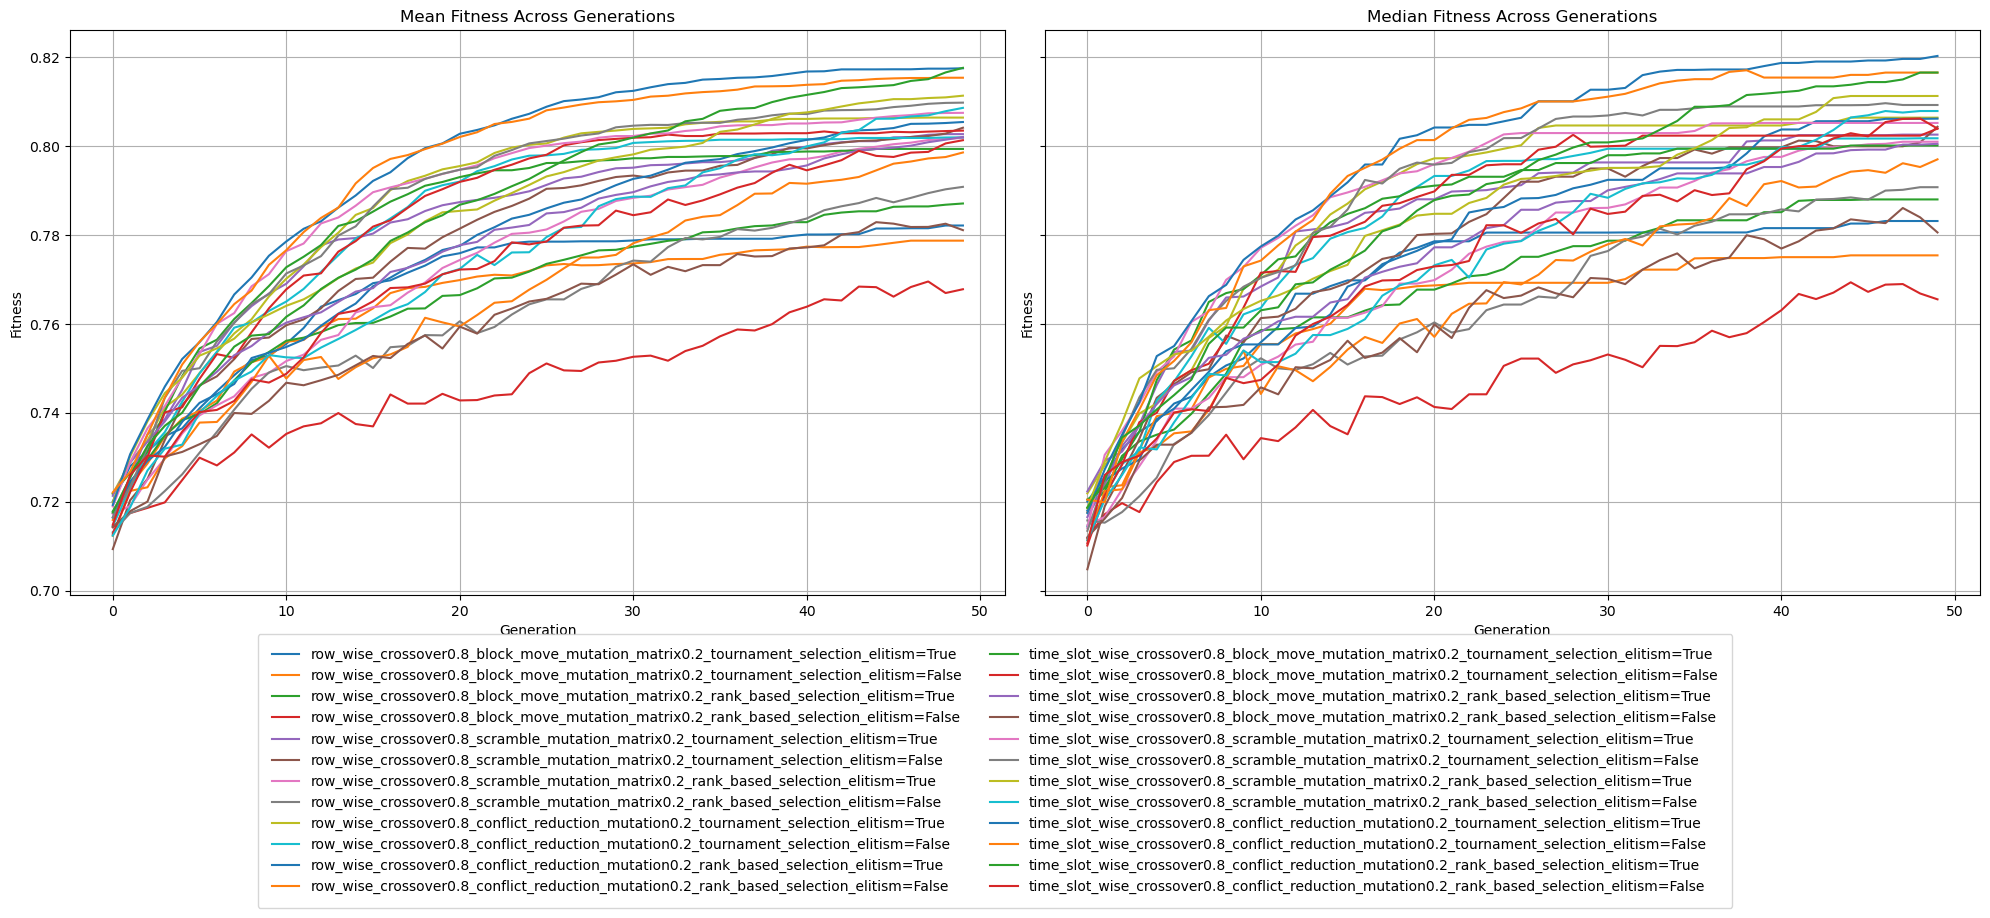

In [106]:
plot_fitness_over_gen(fitness_dfs)

In [90]:
best_config = None
best_mean_fitness = -float('inf')  # For maximization
results_summary = []

for config_label, df in fitness_dfs.items():
    final_gen_fitness = df[GENERATIONS - 1]
    mean_fitness = final_gen_fitness.mean()
    median_fitness = final_gen_fitness.median()
    
    results_summary.append((config_label, mean_fitness, median_fitness))
    
    if mean_fitness > best_mean_fitness:
        best_mean_fitness = mean_fitness
        best_config = config_label

# Print mean and median for every configuration
print("\nMean and Median Final Fitness by Configuration:")
for config_label, mean_fitness, median_fitness in results_summary:
    print(f"{config_label}: mean = {mean_fitness:.2f}, median = {median_fitness:.2f}")

# Print the best config
print(f"\nBest Configuration:\n{best_config} with mean final fitness {best_mean_fitness:.2f}")




Mean and Median Final Fitness by Configuration:
row_wise_crossover0.8_block_move_mutation_matrix0.2_tournament_selection_elitism=True: mean = 0.78, median = 0.78
row_wise_crossover0.8_block_move_mutation_matrix0.2_tournament_selection_elitism=False: mean = 0.78, median = 0.78
row_wise_crossover0.8_block_move_mutation_matrix0.2_rank_based_selection_elitism=True: mean = 0.79, median = 0.79
row_wise_crossover0.8_block_move_mutation_matrix0.2_rank_based_selection_elitism=False: mean = 0.77, median = 0.77
row_wise_crossover0.8_scramble_mutation_matrix0.2_tournament_selection_elitism=True: mean = 0.80, median = 0.80
row_wise_crossover0.8_scramble_mutation_matrix0.2_tournament_selection_elitism=False: mean = 0.80, median = 0.80
row_wise_crossover0.8_scramble_mutation_matrix0.2_rank_based_selection_elitism=True: mean = 0.80, median = 0.80
row_wise_crossover0.8_scramble_mutation_matrix0.2_rank_based_selection_elitism=False: mean = 0.79, median = 0.79
row_wise_crossover0.8_conflict_reduction_mu

In [108]:
crossover_names = ["row_wise_crossover", "time_slot_wise_crossover"]
mutation_names = ["block_move_mutation_matrix", "scramble_mutation_matrix", "conflict_reduction_mutation"]

crossover_fit_dfs = {}
mutation_fit_dfs = {}

# Combine all isolated runs using a given crossover
for crossover_name in crossover_names:
    dfs_to_concat = []
    for df_name, df in fitness_dfs.items():
        if crossover_name in df_name:
            dfs_to_concat.append(df)

    crossover_fit_dfs[crossover_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)

# Combine all isolated runs using a given mutation
for mutation_name in mutation_names:
    dfs_to_concat = []
    for df_name, df in fitness_dfs.items():
        if mutation_name in df_name:
            dfs_to_concat.append(df)
    mutation_fit_dfs[mutation_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)

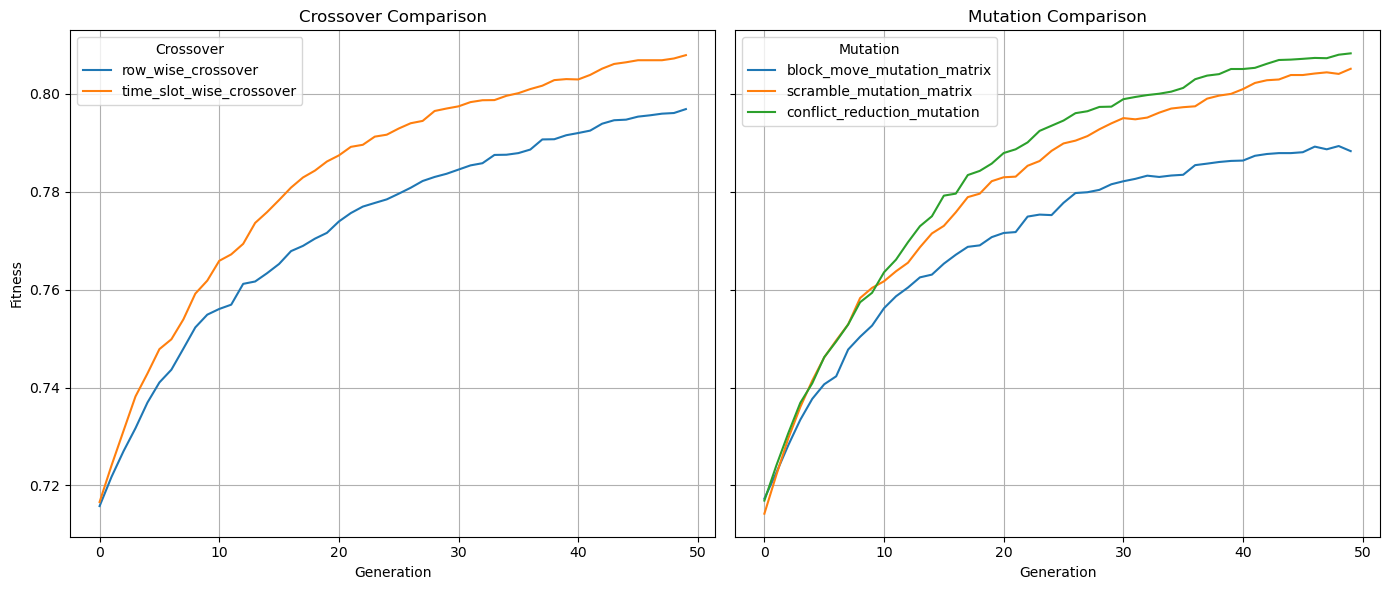

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot crossover results
for name, df in crossover_fit_dfs.items():
    mean_fitness = df.median(axis=0)
    axes[0].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[0].set_title("Crossover Comparison")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("Fitness")
axes[0].legend(title="Crossover")
axes[0].grid(True)

# Plot mutation results
for name, df in mutation_fit_dfs.items():
    mean_fitness = df.median(axis=0)
    axes[1].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[1].set_title("Mutation Comparison")
axes[1].set_xlabel("Generation")
axes[1].legend(title="Mutation")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
grid_params = {
    "xo_prob": [random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)],
    "mut_prob": [random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)]
}

finetune_fitness_results = {}

for xo_prob in grid_params["xo_prob"]:
    for mut_prob in grid_params["mut_prob"]:
        config_results = []

        for run_nr in range(30):
            best_solution, _ = genetic_algorithm(
                initial_population=[
                ArtistLineupSolutionGA(
                    crossover_function=time_slot_wise_crossover,
                    mutation_function=conflict_reduction_mutation,
                    conflict_matrix=conflict_matrix,
                    artists=artists
                ) for _ in range(POP_SIZE)
            ],
            max_gen=GENERATIONS,
            selection_algorithm=rank_based_selection,
            xo_prob=xo_prob,
            mut_prob=mut_prob,
            elitism=True
            )
            config_results.append(best_solution.fitness())

        # Create a label for the config
        config_label = f"xo_prob={round(xo_prob, 2)}_mut_prob={round(mut_prob, 2)}"
    
        finetune_fitness_results[config_label] = config_results

In [ ]:
# Convert the results into a long-format DataFrame for Seaborn
data = []
for config_label, fitness_values in finetune_fitness_results.items():
    for value in fitness_values:
        data.append({
            'value': value,
            'group': config_label
        })

df_long = pd.DataFrame(data)

# Set a beautiful theme using Seaborn
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

# Create the plot
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='group', y='value', data=df_long, width=0.5, linewidth=2.5, fliersize=4)

# Titles and labels
plt.title('Finetuning results (xo_prob and mut_prob)', fontsize=16)
plt.ylabel('Fitness of best found individual', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()